In [9]:
from typing import List, TypedDict
import time

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv

load_dotenv()

True

In [10]:
docs = (
    PyPDFLoader(r"Documents\Bradley Hope, Justin Scheck - Blood and Oil_ Mohammed bin Salman's Ruthless Quest for Global Power-Hachette Books (2020)(Z-Lib.io).pdf").load() +
    PyPDFLoader(r"Documents\David Graeber, David Wengrow - The Dawn of Everything_ A New History of Humanity-Farrar, Straus and Giroux (2021)(Z-Lib.io).pdf").load() +
    PyPDFLoader(r"./documents/Ishtiaq Ahmed - The Pakistan Garrison State_ Origins, Evolution, Consequences (1947-2011) (2013, Oxford University Press) - libgen.li.pdf").load() +
    PyPDFLoader(r"./documents/The Return of the Taliban_ Afghanistan after the Americans.pdf").load()
)


In [11]:
len(docs)

1855

In [12]:
chunks = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=150).split_documents(docs)

# 3) Clean text to avoid UnicodeEncodeError (surrogates from PDF extraction)
for d in chunks:
    d.page_content = d.page_content.encode("utf-8", "ignore").decode("utf-8", "ignore")

In [13]:
len(chunks)

4035

In [14]:
# 3) Index (fresh collection each run)
embeddings = OpenAIEmbeddings(model='text-embedding-3-small', dimensions=1024)
vector_store = FAISS.from_documents(chunks, embeddings)

In [11]:
retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k':4})

In [12]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [13]:
class State(TypedDict):
    question: str
    docs: List[Document]
    answer: str

In [14]:
def retrieve(state):
    q = state["question"]
    return {"docs": retriever.invoke(q)}

In [57]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Answer only from the context. If not in context, say you don't know."),
        ("human", "Question: {question}\n\nContext:\n{context}"),
    ]
)
def generate(state):
    context = "\n\n".join(d.page_content for d in state["docs"])
    out = (prompt | llm).invoke({"question": state["question"], "context": context})
    return {"answer": out.content}

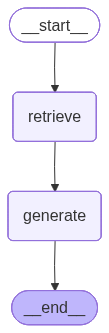

In [58]:
g = StateGraph(State)
g.add_node("retrieve", retrieve)
g.add_node("generate", generate)
g.add_edge(START, "retrieve")
g.add_edge("retrieve", "generate")
g.add_edge("generate", END)
app = g.compile()

app

In [59]:
# 5) Run
res = app.invoke({"question": "Views of Muhammad Bin Salman on Iran", "docs": [], "answer": ""})
print(res["answer"])

The context does not provide specific views of Muhammad Bin Salman on Iran. It discusses the broader sentiments of Saudi Arabia's leadership, particularly in relation to the Iran nuclear deal and the perceived threat of Iran as a regional power. Muhammad Bin Salman expressed dismay at the U.S. approach to Iran under President Obama, viewing it as a betrayal of Saudi interests. However, his specific views are not detailed in the provided text.


In [60]:
print(res['docs'][0].page_content)
print('*'*100)
print(res['docs'][1].page_content)
print('*'*100)
print(res['docs'][2].page_content)
print('*'*100)
print(res['docs'][3].page_content)

Safavid empire that had dominated much of the region three centuries earlier.
In a discussion with Admiral Kevin Cosgriff in June 2007, Mohammed
bin Zayed summarized his cultural viewpoint succinctly. “Any culture that is
patient and focused enough to spend years working on a single carpet is
capable of waiting years and even decades to achieve even greater goals,” he
told Cosgriff, according to a leaked State Department cable. Iran’s goal was
“a new Greater Persian Empire wielding the influence of a nuclear weapon.”
Mohammed and Bannon went on for another hour, talking about history,
security, and frustration with what they saw as Obama’s dangerously naive
Iran deal. Then the Emirati made a suggestion: The Trump camp should meet
Mohammed bin Salman. “He’s the key to your plans in the region,” he said.
The suggestion was just one way that the Emiratis were bolstering the
****************************************************************************************************
its use of chem

NOW ADDING THE KNOWLEDGE REFINEMENT PART 
Adding a knowledge refinement step to the graph, where the model can iteratively refine its retrieved knowledge based on the question and previous context.
 This can help improve the relevance of the retrieved documents and ultimately lead to better answers.
the change is 
retieval -> stripped into single line sentences -> iteratively each sentence relevance is found 
-> if relevant keep that strip and append to a refiend list else discard 
-> refined list is then used as context for answer generation

In [61]:
# making a new graph with refinement
    

class State(TypedDict):
    question: str
    docs: List[Document]

    #change
    strips: List[str]
    kept_strips: List[str]
    refined_context: str

    answer: str

In [62]:
import re

In [63]:
from pydantic import BaseModel

In [64]:
# -----------------------------
# Sentence-level DECOMPOSER
# -----------------------------
def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]


# -----------------------------
# FILTER (LLM judge)
# -----------------------------
class KeepOrDrop(BaseModel):
    keep: bool

filter_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a strict relevance filter for RAG.\n"
            "Evaluate whether the given sentence directly answers the user’s question.\n"
            "Output JSON ONLY in the format: {{{{\"keep\": true/false}}}}.\n"
            "Use only the information in the sentence. Do NOT add or infer anything.",
        ),
        (
            "human",
            "Question: {question}\n\nSentence: {sentence}\n\n"
            "Decide if the sentence is strictly relevant to the question.",
        ),
    ]
)


filter_chain = filter_prompt | llm.with_structured_output(KeepOrDrop)


# -----------------------------
# REFINING (Decompose -> Filter -> Recompose)
# -----------------------------
def refine(state: State) -> State:

    q = state["question"]

    # Combine retrieved docs into one context string
    context = "\n\n".join(d.page_content for d in state["docs"]).strip()

    # 1) DECOMPOSITION: context -> sentence strips
    strips = decompose_to_sentences(context)

    # 2) FILTER: keep only relevant strips
    kept: List[str] = []
    
    for s in strips:
        if filter_chain.invoke({"question": q, "sentence": s}).keep:
            kept.append(s)

    # 3) RECOMPOSE: glue kept strips back together (internal knowledge)
    refined_context = "\n".join(kept).strip()

    return {
        "strips": strips,
        "kept_strips": kept,
        "refined_context": refined_context,
    }


In [65]:
answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a strict knowledge assistant specializing in political and historical topics. "
            "Answer the user’s question ONLY using the provided refined bullets extracted from the four user-provided political books.\n"
            "Do NOT add, infer, or assume any information not present in the bullets.\n"
            "If the bullets are empty or insufficient to answer, respond exactly: 'I don't know based on the provided documents.'",
        ),
        (
            "human",
            "Question: {question}\n\nRefined context:\n{refined_context}\n\n"
            "Answer the question using ONLY the above bullets.",
        ),
    ]
)

def generate(state: State) -> State:
    out = (answer_prompt | llm).invoke({
        "question": state["question"],
        "refined_context": state["refined_context"]
    })
    return {"answer": out.content}


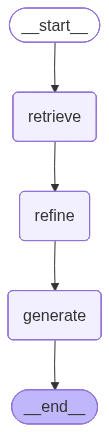

In [66]:
g = StateGraph(State)
g.add_node("retrieve", retrieve)
g.add_node("refine", refine)
g.add_node("generate", generate)

g.add_edge(START, "retrieve")
g.add_edge("retrieve", "refine")
g.add_edge("refine", "generate")
g.add_edge("generate", END)

app = g.compile()

app

In [69]:

class State(TypedDict):
    question: str
    docs: List[Document]
    strips: List[str]
    kept_strips: List[str]
    refined_context: str
    answer: str

def retrieve(state):
    q = state["question"]
    return {"docs": retriever.invoke(q)}

def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]

class RelevanceScore(BaseModel):
    score: int  # 0 = not relevant, 1 = possibly relevant, 2 = relevant

filter_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "Rate how relevant this sentence is to answering the question.\n"
        "Score 0: Completely irrelevant\n"
        "Score 1: Somewhat related or provides context\n"
        "Score 2: Directly answers or strongly supports answering the question\n"
        "Be LENIENT - if there's any connection, score at least 1."
    ),
    (
        "human",
        "Question: {question}\n\nSentence: {sentence}\n\nProvide only the score."
    )
])

filter_chain = filter_prompt | llm.with_structured_output(RelevanceScore)

def refine(state: State) -> State:
    q = state["question"]
    context = "\n\n".join(d.page_content for d in state["docs"]).strip()
    
    strips = decompose_to_sentences(context)
    
    if not strips:
        return {
            "strips": [],
            "kept_strips": [],
            "refined_context": ""
        }
    
    kept = []
    for s in strips:
        try:
            result = filter_chain.invoke({"question": q, "sentence": s})
            # Keep sentences with score >= 1 (more lenient)
            if result.score >= 1:
                kept.append(s)
        except:
            # If LLM fails, keep the sentence by default
            kept.append(s)
    
    refined_context = "\n".join(kept).strip()
    
    return {
        "strips": strips,
        "kept_strips": kept,
        "refined_context": refined_context
    }

answer_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a knowledgeable assistant. Answer the question using the provided context. "
        "Synthesize information from multiple sentences if needed. "
        "If there is insufficient information, say 'I don't have enough information to answer this question.'"
    ),
    (
        "human",
        "Question: {question}\n\nContext:\n{refined_context}\n\nAnswer:"
    )
])

def generate(state: State) -> State:
    if not state["refined_context"].strip():
        return {"answer": "I don't have enough information to answer this question."}
    
    out = (answer_prompt | llm).invoke({
        "question": state["question"],
        "refined_context": state["refined_context"]
    })
    return {"answer": out.content}

g = StateGraph(State)
g.add_node("retrieve", retrieve)
g.add_node("refine", refine)
g.add_node("generate", generate)

g.add_edge(START, "retrieve")
g.add_edge("retrieve", "refine")
g.add_edge("refine", "generate")
g.add_edge("generate", END)

app = g.compile()



In [71]:
if __name__ == "__main__":
    res = app.invoke({
        "question": "Role of Military in Pakistan's politics",
    })
    
    print(f"Answer: {res['answer']}\n")
    print(f"Kept {len(res['kept_strips'])} out of {len(res['strips'])} strips")
    print("\nKept strips preview:")
    for i, strip in enumerate(res['kept_strips'][:3]):
        print(f"{i+1}. {strip[:100]}...")

Answer: The military in Pakistan plays a significant and complex role in the country's politics. Historically, the military has been a dominant force, influencing political decisions and shaping policy, particularly in relation to security and counter-terrorism efforts. The context indicates that the military, specifically the Inter-Services Intelligence (ISI), has engaged in negotiations and strategic relationships with groups like the Afghan Taliban, reflecting its involvement in regional security dynamics.

The military's actions have included attempts to manage and counteract the influence of the Tehrik-i-Taliban Pakistan (TTP) and other militant groups, which have historically enjoyed a mutually beneficial relationship with the Afghan Taliban. This has led to tensions between Pakistan and Afghanistan, as the military's strategies have not always yielded the desired outcomes.

Moreover, the military's approach to domestic dissent, such as the Pashtun Tahafuz Movement (PTM), illustr

In [72]:
UPPER_TH = 0.7
LOWER_TH = 0.3
class State(TypedDict):
    question: str

    docs: List[Document]
    good_docs: List[Document]

    verdict: str
    reason: str

    strips: List[str]
    kept_strips: List[str]
    refined_context: str

    web_query: str
    
    web_docs: List[Document]

    answer: str

Implementing rest of CRAG ( 3 categories -> correct,incorrect,middle and web search )

In [74]:
from langchain_community.tools.tavily_search import TavilySearchResults

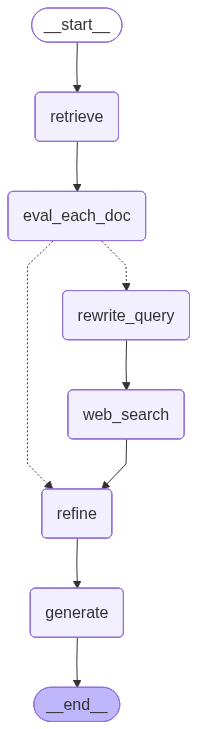

In [80]:
class DocEvalScore(BaseModel):
    score: float
    reason: str


doc_eval_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a strict retrieval evaluator for RAG.\n"
            "You will be given ONE retrieved chunk and a question.\n"
            "Return a relevance score in [0.0, 1.0].\n"
            "- 1.0: chunk alone is sufficient to answer fully/mostly\n"
            "- 0.0: chunk is irrelevant\n"
            "Be conservative with high scores.\n"
            "Also return a short reason.\n"
            "Output JSON only.",
        ),
        ("human", "Question: {question}\n\nChunk:\n{chunk}"),
    ]
)

doc_eval_chain = doc_eval_prompt | llm.with_structured_output(DocEvalScore)


def eval_each_doc_node(state: State) -> State:
    q = state["question"]
    scores: List[float] = []
    good: List[Document] = []

    for d in state["docs"]:
        out = doc_eval_chain.invoke({"question": q, "chunk": d.page_content})
        scores.append(out.score)

        # Keep any doc above LOWER_TH as "weakly relevant"
        if out.score > LOWER_TH:
            good.append(d)

    # CORRECT: at least one doc > UPPER_TH
    if any(s > UPPER_TH for s in scores):
        return {
            "good_docs": good,
            "verdict": "CORRECT",
            "reason": f"At least one retrieved chunk scored > {UPPER_TH}.",
        }

    # INCORRECT: all docs < LOWER_TH
    if len(scores) > 0 and all(s < LOWER_TH for s in scores):
        return {
            "good_docs": [],
            "verdict": "INCORRECT",
            "reason": f"All retrieved chunks scored < {LOWER_TH}.",
        }

    # AMBIGUOUS: otherwise
    return {
        "good_docs": good,
        "verdict": "AMBIGUOUS",
        "reason": f"No chunk scored > {UPPER_TH}, but not all were < {LOWER_TH}.",
    }


def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]


# -----------------------------
# FILTER (LLM judge)
# -----------------------------
class KeepOrDrop(BaseModel):
    keep: bool


filter_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a strict relevance filter.\n"
            "Return keep=true only if the sentence directly helps answer the question.\n"
            "Use ONLY the sentence. Output JSON only.",
        ),
        ("human", "Question: {question}\n\nSentence:\n{sentence}"),
    ]
)

filter_chain = filter_prompt | llm.with_structured_output(KeepOrDrop)


# -----------------------------
# Knowledge refinement
# (CORRECT => internal only)
# (INCORRECT => web only)
# (AMBIGUOUS => internal + web)
# -----------------------------
def refine(state: State) -> State:
    q = state["question"]

    if state.get("verdict") == "CORRECT":
        docs_to_use = state["good_docs"]
    elif state.get("verdict") == "INCORRECT":
        docs_to_use = state["web_docs"]
    else:  # AMBIGUOUS
        docs_to_use = state["good_docs"] + state["web_docs"]

    context = "\n\n".join(d.page_content for d in docs_to_use).strip()

    strips = decompose_to_sentences(context)

    kept: List[str] = []
    for s in strips:
        if filter_chain.invoke({"question": q, "sentence": s}).keep:
            kept.append(s)

    refined_context = "\n".join(kept).strip()

    return {
        "strips": strips,
        "kept_strips": kept,
        "refined_context": refined_context,
    }


class WebQuery(BaseModel):
    query: str


rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Rewrite the user question into a web search query composed of keywords.\n"
            "Rules:\n"
            "- Keep it short (6–14 words).\n"
            "- If the question implies recency (e.g., recent/latest/last week/last month), add a constraint like (last 30 days).\n"
            "- Do NOT answer the question.\n"
            "- Return JSON with a single key: query",
        ),
        ("human", "Question: {question}"),
    ]
)

rewrite_chain = rewrite_prompt | llm.with_structured_output(WebQuery)


def rewrite_query_node(state: State) -> State:
    out = rewrite_chain.invoke({"question": state["question"]})
    return {"web_query": out.query}

def retrieve_node(state: State) -> State:
    q = state["question"]
    return {"docs": retriever.invoke(q)}

# -----------------------------
# Web search node: uses web_query
# -----------------------------
tavily = TavilySearchResults(max_results=5, api_key=os.getenv("TAVILY_API_KEY"))


def web_search_node(state: State) -> State:
    q = state.get("web_query") or state["question"]
    results = tavily.invoke({"query": q})

    web_docs: List[Document] = []
    for r in results or []:
        title = r.get("title", "")
        url = r.get("url", "")
        content = r.get("content", "") or r.get("snippet", "")
        text = f"TITLE: {title}\nURL: {url}\nCONTENT:\n{content}"
        web_docs.append(Document(page_content=text, metadata={"url": url, "title": title}))

    return {"web_docs": web_docs}


answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful ML tutor. Answer ONLY using the provided context.\n"
            "If the context is empty or insufficient, say: 'I don't know.'",
        ),
        ("human", "Question: {question}\n\nContext:\n{context}"),
    ]
)


def generate(state: State) -> State:
    out = (answer_prompt | llm).invoke({"question": state["question"], "context": state["refined_context"]})
    return {"answer": out.content}


def route_after_eval(state: State) -> str:
    if state["verdict"] == "CORRECT":
        return "refine"
    else:
        return "rewrite_query"
    

g = StateGraph(State)

g.add_node("retrieve", retrieve_node)
g.add_node("eval_each_doc", eval_each_doc_node)

g.add_node("rewrite_query", rewrite_query_node)
g.add_node("web_search", web_search_node)

g.add_node("refine", refine)
g.add_node("generate", generate)

g.add_edge(START, "retrieve")
g.add_edge("retrieve", "eval_each_doc")

g.add_conditional_edges(
    "eval_each_doc",
    route_after_eval,
    {
        "refine": "refine",
        "rewrite_query": "rewrite_query",
    },
)

# non-correct path
g.add_edge("rewrite_query", "web_search")
g.add_edge("web_search", "refine")

# correct path already goes to refine
g.add_edge("refine", "generate")
g.add_edge("generate", END)

app = g.compile()

app

In [81]:
res = app.invoke(
    {
        "question": "Ashraf Ghani's views on Taliban's return to power in Afghanistan",
        "docs": [],
        "good_docs": [],
        "verdict": "",
        "reason": "",
        "strips": [],
        "kept_strips": [],
        "refined_context": "",
        "web_query": "",
        "web_docs": [],
        "answer": "",
    }
)

print("VERDICT:", res["verdict"])
print("REASON:", res["reason"])
print("WEB_QUERY:", res["web_query"])
print("\nOUTPUT:\n", res["answer"])

VERDICT: AMBIGUOUS
REASON: No chunk scored > 0.7, but not all were < 0.3.
WEB_QUERY: Ashraf Ghani Taliban return to power views

OUTPUT:
 Ashraf Ghani expressed a complex view on the Taliban's return to power in Afghanistan. He acknowledged the potential for conflict between different factions of the Taliban as they closed in on Kabul, which he believed could lead to significant destruction and suffering for the city's population. Despite this, he advocated for a Loya Jirga to help legitimize the Taliban regime and emphasized the need for reforms. Ghani also expressed a willingness to recognize the Taliban as a legitimate political group and offered Afghan passports to them, indicating a desire to strike a peace deal. He highlighted the importance of democratic processes, suggesting that he wanted to convince the Taliban to hold fresh elections and form a new government, reflecting concerns about the return of the old style of Taliban governance.


CREATING AN OPTIMIZED VERSION OF THE CODE BY REMOVING LLM AS AN EVALUATOR 
RATHER JUST USING 2 API CALLS ( 1 FOR TAVILY SEARCH AND 1 FOR FINAL TEXT GENERATION )

In [15]:
"""
Optimized Corrective RAG (CRAG) Implementation
- Uses pre-embedded chunks from separate notebook
- No LLM-based document evaluation
- Embedding-based relevance scoring only
- Web search integration for low-confidence scenarios
"""

from typing import List, TypedDict, Literal
import re
import numpy as np
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
import os

load_dotenv()

# ============================================
# CONFIGURATION
# ============================================
UPPER_THRESHOLD = 0.65  # High confidence - use internal docs only
LOWER_THRESHOLD = 0.35  # Low confidence - trigger web search
# Between thresholds = AMBIGUOUS - use both internal + web

# ============================================
# STATE DEFINITION
# ============================================
class CRAGState(TypedDict):
    question: str
    
    # Retrieval
    docs: List[Document]
    doc_scores: List[float]  # Cosine similarity scores
    
    # Evaluation verdict
    verdict: Literal["CORRECT", "INCORRECT", "AMBIGUOUS"]
    max_score: float
    
    # Knowledge refinement
    selected_docs: List[Document]
    refined_sentences: List[str]
    refined_context: str
    
    # Web search (if needed)
    web_query: str
    web_docs: List[Document]
    
    # Final output
    answer: str


# ============================================
# LOAD PRE-EMBEDDED DATA
# ============================================
def load_precomputed_vectorstore(
    chunks: List[Document],
    embeddings: OpenAIEmbeddings
) -> FAISS:
    """
    Load pre-chunked and pre-embedded documents.
    Call this ONCE at startup with your existing chunks variable.
    """
    return FAISS.from_documents(chunks, embeddings)


# ============================================
# RETRIEVAL NODE (with scoring)
# ============================================
def retrieve_with_scores(
    state: CRAGState,
    retriever,
    embeddings: OpenAIEmbeddings
) -> CRAGState:
    """
    Retrieve documents and compute cosine similarity scores.
    NO LLM calls - pure embedding-based scoring.
    """
    q = state["question"]
    
    # Get top-k documents
    docs = retriever.invoke(q)
    
    # Compute cosine similarity scores
    question_embedding = embeddings.embed_query(q)
    doc_embeddings = embeddings.embed_documents([d.page_content for d in docs])
    
    scores = []
    for doc_emb in doc_embeddings:
        similarity = np.dot(question_embedding, doc_emb) / (
            np.linalg.norm(question_embedding) * np.linalg.norm(doc_emb)
        )
        scores.append(float(similarity))
    
    return {
        "docs": docs,
        "doc_scores": scores
    }


# ============================================
# EVALUATION NODE (embedding-based only)
# ============================================
def evaluate_retrieval(state: CRAGState) -> CRAGState:
    """
    Determine CORRECT/INCORRECT/AMBIGUOUS based on embedding scores only.
    NO LLM calls.
    """
    scores = state["doc_scores"]
    max_score = max(scores) if scores else 0.0
    
    if max_score >= UPPER_THRESHOLD:
        verdict = "CORRECT"
    elif max_score < LOWER_THRESHOLD:
        verdict = "INCORRECT"
    else:
        verdict = "AMBIGUOUS"
    
    return {
        "verdict": verdict,
        "max_score": max_score
    }


# ============================================
# SENTENCE REFINEMENT (embedding-based)
# ============================================
def decompose_to_sentences(text: str) -> List[str]:
    """Split text into sentences."""
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]


def refine_knowledge_embedding_based(
    state: CRAGState,
    embeddings: OpenAIEmbeddings,
    sentence_threshold: float = 0.40
) -> CRAGState:
    """
    Refine knowledge using ONLY embedding similarity.
    NO LLM calls for sentence filtering.
    """
    q = state["question"]
    verdict = state["verdict"]
    
    # Select documents based on verdict
    if verdict == "CORRECT":
        # Use only internal high-scoring docs
        docs_to_use = [
            d for d, s in zip(state["docs"], state["doc_scores"])
            if s >= LOWER_THRESHOLD
        ]
    elif verdict == "INCORRECT":
        # Use only web search results
        docs_to_use = state.get("web_docs", [])
    else:  # AMBIGUOUS
        # Combine internal + web
        internal = [
            d for d, s in zip(state["docs"], state["doc_scores"])
            if s >= LOWER_THRESHOLD
        ]
        docs_to_use = internal + state.get("web_docs", [])
    
    if not docs_to_use:
        return {
            "selected_docs": [],
            "refined_sentences": [],
            "refined_context": ""
        }
    
    # Decompose into sentences
    all_text = "\n\n".join(d.page_content for d in docs_to_use)
    sentences = decompose_to_sentences(all_text)
    
    if not sentences:
        return {
            "selected_docs": docs_to_use,
            "refined_sentences": [],
            "refined_context": all_text
        }
    
    # Embedding-based sentence filtering
    question_embedding = embeddings.embed_query(q)
    sentence_embeddings = embeddings.embed_documents(sentences)
    
    kept_sentences = []
    for sent, sent_emb in zip(sentences, sentence_embeddings):
        similarity = np.dot(question_embedding, sent_emb) / (
            np.linalg.norm(question_embedding) * np.linalg.norm(sent_emb)
        )
        if similarity >= sentence_threshold:
            kept_sentences.append(sent)
    
    refined_context = "\n".join(kept_sentences) if kept_sentences else all_text
    
    return {
        "selected_docs": docs_to_use,
        "refined_sentences": kept_sentences,
        "refined_context": refined_context
    }


# ============================================
# WEB SEARCH NODES
# ============================================
def rewrite_query_for_web(
    state: CRAGState,
    llm: ChatOpenAI
) -> CRAGState:
    """
    Generate web search query (minimal LLM use).
    Only called when verdict is INCORRECT or AMBIGUOUS.
    """
    rewrite_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            "Convert the question into a concise web search query (6-12 keywords).\n"
            "If recency is implied, add time constraint.\n"
            "Return only the query string, no explanation."
        ),
        ("human", "{question}")
    ])
    
    response = (rewrite_prompt | llm).invoke({"question": state["question"]})
    web_query = response.content.strip()
    
    return {"web_query": web_query}


def web_search(
    state: CRAGState,
    tavily_api_key: str
) -> CRAGState:
    """
    Execute web search using rewritten query.
    """
    tavily = TavilySearchResults(
        max_results=3,
        api_key=tavily_api_key
    )
    
    query = state.get("web_query") or state["question"]
    results = tavily.invoke({"query": query})
    
    web_docs = []
    for r in results or []:
        title = r.get("title", "")
        url = r.get("url", "")
        content = r.get("content", "") or r.get("snippet", "")
        text = f"TITLE: {title}\nURL: {url}\nCONTENT:\n{content}"
        web_docs.append(Document(
            page_content=text,
            metadata={"url": url, "title": title, "source": "web"}
        ))
    
    return {"web_docs": web_docs}


# ============================================
# ANSWER GENERATION
# ============================================
def generate_answer(
    state: CRAGState,
    llm: ChatOpenAI
) -> CRAGState:
    """
    Generate final answer using refined context.
    """
    answer_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            "You are a knowledgeable assistant. Answer using ONLY the provided context.\n"
            "If insufficient information, say 'I don't have enough information to answer.'"
        ),
        (
            "human",
            "Question: {question}\n\nContext:\n{context}\n\nAnswer:"
        )
    ])
    
    context = state["refined_context"]
    if not context.strip():
        return {"answer": "I don't have enough information to answer this question."}
    
    response = (answer_prompt | llm).invoke({
        "question": state["question"],
        "context": context
    })
    
    return {"answer": response.content}


# ============================================
# ROUTING LOGIC
# ============================================
def route_after_evaluation(state: CRAGState) -> str:
    """
    Route based on verdict:
    - CORRECT: skip web search, go directly to refinement
    - INCORRECT or AMBIGUOUS: rewrite query for web search
    """
    if state["verdict"] == "CORRECT":
        return "refine"
    else:
        return "web_search_path"


# ============================================
# GRAPH CONSTRUCTION
# ============================================
def build_crag_graph(
    retriever,
    embeddings: OpenAIEmbeddings,
    llm: ChatOpenAI,
    tavily_api_key: str
):
    """
    Build the complete CRAG graph with optimized nodes.
    """
    graph = StateGraph(CRAGState)
    
    # Add nodes
    graph.add_node(
        "retrieve",
        lambda state: retrieve_with_scores(state, retriever, embeddings)
    )
    
    graph.add_node("evaluate", evaluate_retrieval)
    
    graph.add_node(
        "rewrite_query",
        lambda state: rewrite_query_for_web(state, llm)
    )
    
    graph.add_node(
        "web_search",
        lambda state: web_search(state, tavily_api_key)
    )
    
    graph.add_node(
        "refine",
        lambda state: refine_knowledge_embedding_based(state, embeddings)
    )
    
    graph.add_node(
        "generate",
        lambda state: generate_answer(state, llm)
    )
    
    # Add edges
    graph.add_edge(START, "retrieve")
    graph.add_edge("retrieve", "evaluate")
    
    # Conditional routing after evaluation
    graph.add_conditional_edges(
        "evaluate",
        route_after_evaluation,
        {
            "refine": "refine",
            "web_search_path": "rewrite_query"
        }
    )
    
    # Web search path
    graph.add_edge("rewrite_query", "web_search")
    graph.add_edge("web_search", "refine")
    
    # Final path
    graph.add_edge("refine", "generate")
    graph.add_edge("generate", END)
    
    return graph.compile()


# ============================================
# MAIN EXECUTION FUNCTION
# ============================================
def run_crag_query(
    question: str,
    crag_app,
    verbose: bool = True
):
    """
    Execute a CRAG query and return results.
    """
    initial_state = {
        "question": question,
        "docs": [],
        "doc_scores": [],
        "verdict": "",
        "max_score": 0.0,
        "selected_docs": [],
        "refined_sentences": [],
        "refined_context": "",
        "web_query": "",
        "web_docs": [],
        "answer": ""
    }
    
    result = crag_app.invoke(initial_state)
    
    if verbose:
        print(f"QUESTION: {question}")
        print(f"\nVERDICT: {result['verdict']}")
        print(f"MAX SCORE: {result['max_score']:.3f}")
        print(f"DOCS RETRIEVED: {len(result['docs'])}")
        print(f"SENTENCES KEPT: {len(result['refined_sentences'])}")
        
        if result.get("web_query"):
            print(f"WEB QUERY: {result['web_query']}")
            print(f"WEB DOCS: {len(result.get('web_docs', []))}")
        
        print(f"\nANSWER:\n{result['answer']}")
        print("\n" + "="*80)
    
    return result




In [16]:
# Pass chunks as an argument here
def main(chunks):
    # Setup standard components
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small", dimensions=1024)
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    # 1. Index the chunks (chunks must be passed in)
    vector_store = FAISS.from_documents(chunks, embeddings)
    retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 4})

    # 2. Compile the Graph
    tavily_api_key = os.getenv("TAVILY_API_KEY", "")
    crag_app = build_crag_graph(retriever, embeddings, llm, tavily_api_key)

    # 3. Run
    question = "What is a garrision state and why is Pakistan considered one?"
    run_crag_query(question, crag_app, verbose=True)

# Call main with the global chunks variable
if __name__ == "__main__":
    # Ensure 'chunks' exists from your previous cells (Cell 5)
    if 'chunks' in globals():
        main(chunks)
    else:
        print("Error: 'chunks' variable not found. Please run the document loading cells (Cells 1-5) first.")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_25704\3459329506.py:242: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults(


QUESTION: What is a garrision state and why is Pakistan considered one?

VERDICT: AMBIGUOUS
MAX SCORE: 0.432
DOCS RETRIEVED: 4
SENTENCES KEPT: 17
WEB QUERY: garrison state definition Pakistan reasons
WEB DOCS: 3

ANSWER:
A garrison state is a political construct where the military apparatus dominates civil society, the economy, and political decision-making. Pakistan is considered a garrison state because the army acts as the ultimate arbiter of power, often overruling or removing elected civilian governments. This situation arose due to Pakistan's historical context of insecurity, particularly stemming from the war over Kashmir, which led the country to prioritize defense over development from its inception.

